##### Copyright 2021 The TensorFlow Authors.

In [9]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [10]:
!pip install fluidsynth

In [11]:
!pip install --upgrade pyfluidsynth

In [12]:
!pip install pretty_midi

In [13]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [14]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [15]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

The dataset contains about 1,200 MIDI files.

In [16]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [17]:
sample_file = filenames[1]
print(sample_file)

data\maestro-v2.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [18]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [19]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [20]:
display_audio(pm)

AttributeError: module 'fluidsynth' has no attribute 'Synth'

Do some inspection on the MIDI file. What kinds of instruments are used?

In [21]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [22]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=31, note_name=G1, duration=0.0656
1: pitch=43, note_name=G2, duration=0.0792
2: pitch=44, note_name=G#2, duration=0.0740
3: pitch=32, note_name=G#1, duration=0.0729
4: pitch=34, note_name=A#1, duration=0.0708
5: pitch=46, note_name=A#2, duration=0.0948
6: pitch=48, note_name=C3, duration=0.6260
7: pitch=36, note_name=C2, duration=0.6542
8: pitch=53, note_name=F3, duration=1.7667
9: pitch=56, note_name=G#3, duration=1.7688


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [23]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['1_pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['2_velocity'].append(note.velocity)
    notes['3_step'].append(start - prev_start)
    notes['4_duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [24]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,1_pitch,start,end,2_velocity,3_step,4_duration
0,43,1.032292,1.111458,43,0.000000,0.079167
1,31,1.040625,1.106250,36,0.008333,0.065625
2,44,1.142708,1.216667,45,0.102083,0.073958
3,32,1.144792,1.217708,35,0.002083,0.072917
4,46,1.208333,1.303125,55,0.063542,0.094792


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [25]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

KeyError: 'pitch'

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [26]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [27]:
plot_piano_roll(raw_notes, count=100)

KeyError: 'pitch'

<Figure size 1440x288 with 0 Axes>

Plot the notes for the entire track.

In [28]:
plot_piano_roll(raw_notes)

KeyError: 'pitch'

Check the distribution of each note variable.

In [29]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

ValueError: Could not interpret value `pitch` for parameter `x`

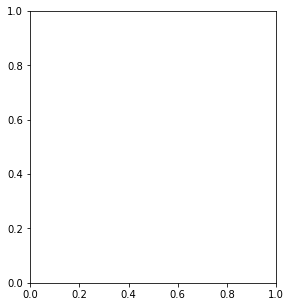

In [30]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [31]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [32]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

KeyError: 'step'

Play the generated MIDI file and see if there is any difference.

In [33]:
display_audio(example_pm)

NameError: name 'example_pm' is not defined

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [34]:
num_files = 50
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [35]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 299680


Next, create a `tf.data.Dataset` from the parsed notes.

In [36]:
key_order = ['1_pitch', '2_velocity', '3_step', '4_duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [37]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(4,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [38]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [39]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 4), dtype=tf.float64, name=None),
 {'1_pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  '2_velocity': TensorSpec(shape=(), dtype=tf.float64, name=None),
  '3_step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  '4_duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [40]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 4)
sequence elements (first 10): tf.Tensor(
[[0.5546875  0.46875    0.         0.096875  ]
 [0.4296875  0.34375    0.18645833 0.21770833]
 [0.5546875  0.421875   0.009375   0.50520833]
 [0.4609375  0.4296875  0.175      0.16770833]
 [0.484375   0.40625    0.16979167 0.11979167]
 [0.5625     0.59375    0.153125   0.04166667]
 [0.5234375  0.4375     0.01666667 0.196875  ]
 [0.578125   0.53125    0.18020833 0.11458333]
 [0.4453125  0.4765625  0.         0.53958333]
 [0.5625     0.6015625  0.05416667 0.06875   ]], shape=(10, 4), dtype=float64)

target: {'1_pitch': <tf.Tensor: shape=(), dtype=float64, numpy=59.0>, '2_velocity': <tf.Tensor: shape=(), dtype=float64, numpy=58.0>, '3_step': <tf.Tensor: shape=(), dtype=float64, numpy=0.008333333333333304>, '4_duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.15937500000000027>}


Batch the examples, and configure the dataset for performance.

In [41]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [42]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 4), dtype=tf.float64, name=None),
 {'1_pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  '2_velocity': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  '3_step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  '4_duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [43]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [44]:
input_shape = (seq_length, 4)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  '1_pitch': tf.keras.layers.Dense(128, name='1_pitch')(x),
  '2_velocity': tf.keras.layers.Dense(128, name='2_velocity')(x),
  '3_step': tf.keras.layers.Dense(1, name='3_step')(x),
  '4_duration': tf.keras.layers.Dense(1, name='4_duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      '1_pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      '2_velocity': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      '3_step': mse_with_positive_pressure,
      '4_duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          68096       ['input_1[0][0]']                
                                                                                                  
 1_pitch (Dense)                (None, 128)          16512       ['lstm[0][0]']                   
                                                                                                  
 2_velocity (Dense)             (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [45]:
losses = model.evaluate(train_ds, return_dict=True)
losses

4682/4682 [==============================] - 24s 2ms/step - loss: 10.0209 - 1_pitch_loss: 4.8544 - 2_velocity_loss: 4.8566 - 3_step_loss: 0.0800 - 4_duration_loss: 0.2299


{'loss': 10.02090835571289,
 '1_pitch_loss': 4.8544206619262695,
 '2_velocity_loss': 4.856593132019043,
 '3_step_loss': 0.08002962917089462,
 '4_duration_loss': 0.22988128662109375}

One way balance this is to use the `loss_weights` argument to compile:

In [46]:
model.compile(
    loss=loss,
    loss_weights={
        '1_pitch': 0.05,
        '2_velocity': 0.05,
        '3_step': 1.0,
        '4_duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [47]:
model.evaluate(train_ds, return_dict=True)

4682/4682 [==============================] - 9s 2ms/step - loss: 0.7955 - 1_pitch_loss: 4.8544 - 2_velocity_loss: 4.8566 - 3_step_loss: 0.0800 - 4_duration_loss: 0.2299


{'loss': 0.7954619526863098,
 '1_pitch_loss': 4.8544206619262695,
 '2_velocity_loss': 4.856593132019043,
 '3_step_loss': 0.08002962917089462,
 '4_duration_loss': 0.22988128662109375}

Train the model.

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=50,
        verbose=1,
        restore_best_weights=True),
]

In [49]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
4682/4682 [==============================] - 15s 3ms/step - loss: 0.5404 - 1_pitch_loss: 3.9567 - 2_velocity_loss: 3.9756 - 3_step_loss: 0.0403 - 4_duration_loss: 0.1035
Epoch 2/10
4682/4682 [==============================] - 14s 3ms/step - loss: 0.5256 - 1_pitch_loss: 3.8783 - 2_velocity_loss: 3.8825 - 3_step_loss: 0.0382 - 4_duration_loss: 0.0993
Epoch 3/10
4682/4682 [==============================] - 14s 3ms/step - loss: 0.5203 - 1_pitch_loss: 3.8549 - 2_velocity_loss: 3.8533 - 3_step_loss: 0.0375 - 4_duration_loss: 0.0975
Epoch 4/10
4682/4682 [==============================] - 14s 3ms/step - loss: 0.5154 - 1_pitch_loss: 3.8212 - 2_velocity_loss: 3.8417 - 3_step_loss: 0.0367 - 4_duration_loss: 0.0955
Epoch 5/10
4682/4682 [==============================] - 14s 3ms/step - loss: 0.5109 - 1_pitch_loss: 3.7940 - 2_velocity_loss: 3.8303 - 3_step_loss: 0.0360 - 4_duration_loss: 0.0937
Epoch 6/10
4682/4682 [==============================] - 14s 3ms/step - loss: 0.5082 - 1_pitch_l

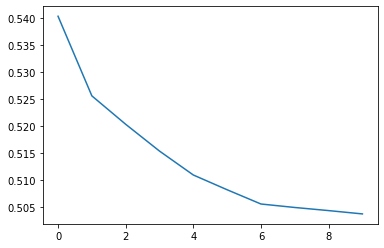

INFO:tensorflow:Assets written to: abc\assets


INFO:tensorflow:Assets written to: abc\assets


In [50]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()
model.save("abc")

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [3]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  velocity = predictions['velocity']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  velocity = tf.squeeze(velocity, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  velocity = tf.maximum(0, velocity)
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), int(pitch), float(step), float(duration)

NameError: name 'np' is not defined

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [4]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, velocity, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, velocity, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

NameError: name 'np' is not defined

In [5]:
generated_notes.head(10)

NameError: name 'generated_notes' is not defined

In [6]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

NameError: name 'notes_to_midi' is not defined

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

In [7]:
plot_piano_roll(generated_notes)

NameError: name 'plot_piano_roll' is not defined

Check the distributions of `pitch`, `step` and `duration`.

In [8]:
plot_distributions(generated_notes)

NameError: name 'plot_distributions' is not defined

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations. 

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).